# Scikit-learn osztályozó algoritmusok összehasonlítása

Ebben a feladatban az alábbi, [scikit-learn](https://scikit-learn.org/stable/index.html) python csomagban megtalálható, alapbeállításokkal létrehozott, egyszerű és összetett osztályozókat hasonlítom össze egy meghatározott adathalmazon végzett bináris osztályosás során elért eredményeik alapján:

- GaussianNB
- DecisionTreeClassifier

- ExtraTreesClassifier
- BaggingClassifier
- AdaBoostClassifier
- RandomForestClassifier
- GradientBoostingClassifier

Az összehasonlítás alapját szolgáló paraméternek a keveredési mátrixból számítható pontosságot ([accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)) és a [ROC görbe](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) alatti területet ([ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)) választottam, kiszámításukhoz a scikit-learn csomag beépített függvényeit használom.

Nem célom a tökéletes osztályozás keresése, csak az algoritmusok alapbeállításokkal történő kipróbálása és összehasonlítása.


## Szükséges python könyvtárak

Valamint a demo-megjelenítéshez néhány beállítás:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

pd.set_option("display.max_columns", 100)
#pd.set_option("display.max_rows", 100)
sns.set_context("poster")

## Az adathalmaz

Közel 10 évnyi időjárás adat Ausztrál városokból napi felbontással.

A kaggle.com oldalról ingyenes regisztrációt követően letölthető:

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

A teljes adathalmaz 23 oszlopot és több mint 140 000 sort tartalmaz, ennek egy részhalmazát használom a bináris osztályozáshoz.

In [2]:
weather = pd.read_csv("./weatherAUS.csv")

weather.describe(include =['object', 'float', 'int'])

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,141232,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2014-10-04,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,10838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,NaN,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,NaN,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,NaN,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,NaN,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,NaN,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


Az első és második oszlop (`"Date"`, `"Location"`: dátum és város) azonosítja az egyes rekordokat,
majd a többi oszlop tartalmazza a mért időjárás adatokat.
Az utolsó két oszlopban lévő időjárás adatok (`"RainToday"`, `"RainTomorrow"`: esős-e az adott illetve az azt követő nap)
származtatott adatok: egyszerűen a napi csapadék mennyiségéből lettek meghatározva.




## Bináris osztályozásra kiválasztott adatok, a feladat megfogalmazása

##### Célváltozó (target, label, response, y)
A kaggle-ös adathalmazhoz kapcsolódóan eredetileg az utolsó oszlopban lévő `"RainTomorrow"` váltózó előrejelzése volt a feladat a városokhoz tartozó idősorok ismeretében. Ettől eltérően én az osztályozáshoz célváltozónak a várost (`"Location"`) választom, valamint nem bocsátom az algoritmusok rendelkezésére a dátum adatot, csak bizonyos időjárás adatokat. Mivel bináris (2 kimenetelű) osztályozást szeretnék végezni, ezért a városok közül is csak 2 tetszőlegesen kiválasztottat fogok használni.

In [3]:
TARGET = "Location"

##### Osztályozáshoz felhasznált oszlopok (attributes, features, descriptors, X)
Azért, hogy minél több algoritmust tudjak használni minél kevesebb adattisztítás mellett, az egyszerűség kedvéért csak a numerikus értékeket tartalmazó oszlopokat használom az osztályozás elvégzéséhez. Ugyanezen okból a hiányzó értékeket tartalmazó sorokat eldobom, ezért a numerikus oszlopok közül is csak azokat veszem figyelembe, amelyek nem túl sok (kevesebb mint 10%) hiányzó adatot tartalmaznak a fenti összegző táblázat alapján.

Így az általam használt oszlopok a következők lesznek:

In [4]:
numerical_columns = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Temp9am",
    "Temp3pm"
]

A bináris osztályozás elvégzésehez 2 tetszőleges várost választok ki (valójában abc rendben az elsőt és az utolsót) és az adathalmazt leszűkítem ennek a 2 városnak az adatait tartalmazó azon sorokra, amik nem tartalmaznak egy hiányzó értékeket sem a fenti 12 oszlopban.


In [5]:
city_1 = "Adelaide"
city_2 = "Woomera"

min_number_of_columns = 1
max_number_of_columns = len(numerical_columns)

dataset_to_make_model = weather[(weather["Location"] == city_1) | (weather["Location"] == city_2)].copy()
dataset_to_make_model.dropna(subset=numerical_columns, inplace=True)

Az így kapott adathalmazon fogok tehát osztályozást végezni: az időjárás adatok alapján eldönteni, hogy a kettő közül melyik város adatairól lehet szó az adott sorban.

## Az osztályozások elvégzése és kiértékelése

Az osztályozókat default beállításokkal hozom létre, kizárólag a véletlenszám generátoraik kezdőállapotát rögzítem a reprodukálhatóság érdekében. Az első 2 osztályozó egyszerű (gyenge) osztályozó, a további 5 darab pedig összetett osztályozó. Az összetett osztályozókat alapbeállításokkal létrehozva döntési fákat használnak a modellek létrehozásakor.

In [6]:
models = {
    "GaussianNB" :            GaussianNB(),
    "DecisionTree" :          DecisionTreeClassifier(random_state=1),
    "Bagging" :               BaggingClassifier(random_state=1),
    "AdaBoost" :              AdaBoostClassifier(random_state=1),
    "RandomForest" :          RandomForestClassifier(random_state=1),
    "ExtraTrees" :            ExtraTreesClassifier(random_state=1),
    "GradientBoosting" :      GradientBoostingClassifier(random_state=1)
}

Az eredményeknek egy pandas dataframe-et hozok létre,
amiben a különböző modellek által elért accuracy és ROC AUC értékeket tárolom,
a rendelkezésükre bocsátott oszlopszám (feature-ök számának) függvényében.

In [7]:
results = pd.DataFrame(columns = ["number_of_columns", "model", "accuracy", "roc_auc"])

Majd a fentebb megadott 12 darab numerikus adatokat tartalmazó oszlop közül
az első 1,2,3,... 12 darabot inputként használva elvégzem a bináris osztályozást mindegyik osztályozóval.

Keresztvalidációt nem használtam, egyszerűen csak tanító és teszt halmazra választom szét a sorokat.

A tanításra (train) és ellenőrzésre (test) mindig ugyanazokat a sorokat használom
a rögzített állapotú véletlenszám generátornak köszönhetően,
a tanító halmazba mindig a sorok ugyanazon 80%-a, a teszt halmazba a sorok maradék 20%-a kerül.

Az accuracy-t a teszt halmazra vonatkozóan a modell által becsült és a tényleges célváltozó értékekből számítható keveredési mátrixból lehet meghatározni. A ROC AUC érték meghatározásához pedig a teszt halmazra vonatkozóan a modell által az adott osztályba tartozás becsült valószínűségeire és a tényleges célváltozó értékeire van szükség.

Mindkét értéket beépített függvények segítségével határoztam meg.

In [8]:
for number_of_features in range(min_number_of_columns, max_number_of_columns + 1) :
    
#    print("============================================================")
#    print("number_of_features =", number_of_features)
#    print()

    feature_columns = numerical_columns[0:number_of_features]

    X = dataset_to_make_model[feature_columns]
    y = dataset_to_make_model[TARGET]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    
    for model_name, model in models.items() :
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        results.loc[len(results.index)] = [number_of_features, model_name, accuracy, roc_auc] 
    
#        print(model_name)
#        print("accuracy_score:", accuracy)
#        print(conf_matrix)
#        print("roc_auc_score:\n", roc_auc)
#        print("\n-----------------------------------")

## Eredmények

A különböző osztályozók által elért pontosság (accuracy) és ROC AUC értékek.


In [9]:
results

,number_of_columns,model,accuracy,roc_auc
0,1,GaussianNB,0.583264,0.612240
1,1,DecisionTree,0.548117,0.565201
2,1,Bagging,0.558159,0.561078
3,1,AdaBoost,0.584937,0.597406
4,1,RandomForest,0.563180,0.566352
...,...,...,...,...
79,12,Bagging,0.870293,0.939580
80,12,AdaBoost,0.862762,0.935740
81,12,RandomForest,0.891213,0.959339
82,12,ExtraTrees,0.892050,0.960998


## Accuracy értékek csak az első oszlop használata esetén

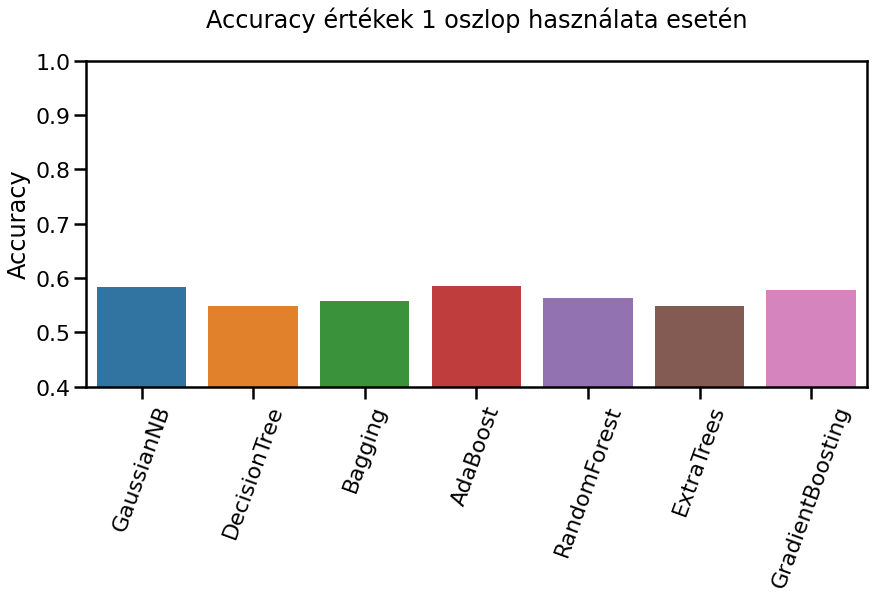

In [10]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="model", y="accuracy", data=results[results["number_of_columns"] == 1])
xticks = plt.xticks(rotation=70)

plt.title("Accuracy értékek 1 oszlop használata esetén\n")
plt.xlabel("")
plt.ylabel("Accuracy")
ylim = plt.ylim(0.4,1.0)

## Accuracy értékek az összes oszlop használata esetén

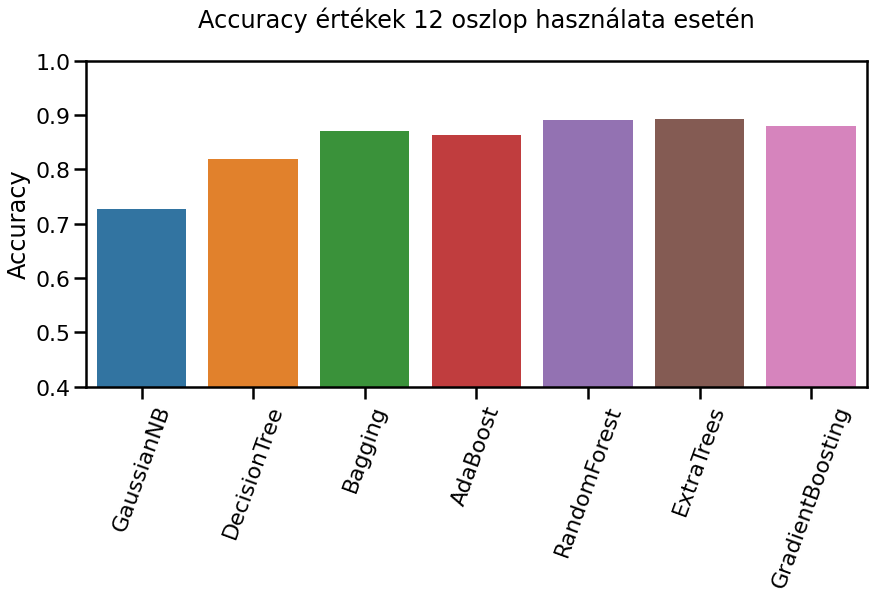

In [11]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="model", y="accuracy", data=results[results["number_of_columns"] == max_number_of_columns])
xticks = plt.xticks(rotation=70)

plt.title(f"Accuracy értékek {max_number_of_columns} oszlop használata esetén\n")
plt.xlabel("")
plt.ylabel("Accuracy")
ylim = plt.ylim(0.4,1.0)

## Accuracy értékek az osztályozáshoz kiválasztott oszlopok számának függvényében:

In [12]:
accuracy_results = results.pivot("number_of_columns", "model", "accuracy")
accuracy_results = accuracy_results.reindex( columns = ["GaussianNB","DecisionTree","Bagging","AdaBoost",
                                                      "RandomForest","ExtraTrees","GradientBoosting"])
accuracy_results

model,GaussianNB,DecisionTree,Bagging,AdaBoost,RandomForest,ExtraTrees,GradientBoosting
number_of_columns,,,,,,,
1,0.583264,0.548117,0.558159,0.584937,0.563180,0.548117,0.577406
2,0.575732,0.562343,0.574059,0.635983,0.591632,0.589958,0.632636
3,0.594979,0.564854,0.609205,0.633473,0.605021,0.610042,0.641841
4,0.601674,0.641841,0.695397,0.710460,0.727197,0.704603,0.741423
5,0.743096,0.780753,0.810042,0.808368,0.820921,0.821757,0.813389
6,0.738075,0.773222,0.815900,0.822594,0.836820,0.848536,0.844351
7,0.734728,0.800837,0.834310,0.825941,0.851046,0.852720,0.866109
8,0.748117,0.852720,0.866109,0.857741,0.876987,0.887029,0.880335
9,0.747280,0.830126,0.878661,0.868619,0.888703,0.889540,0.882845


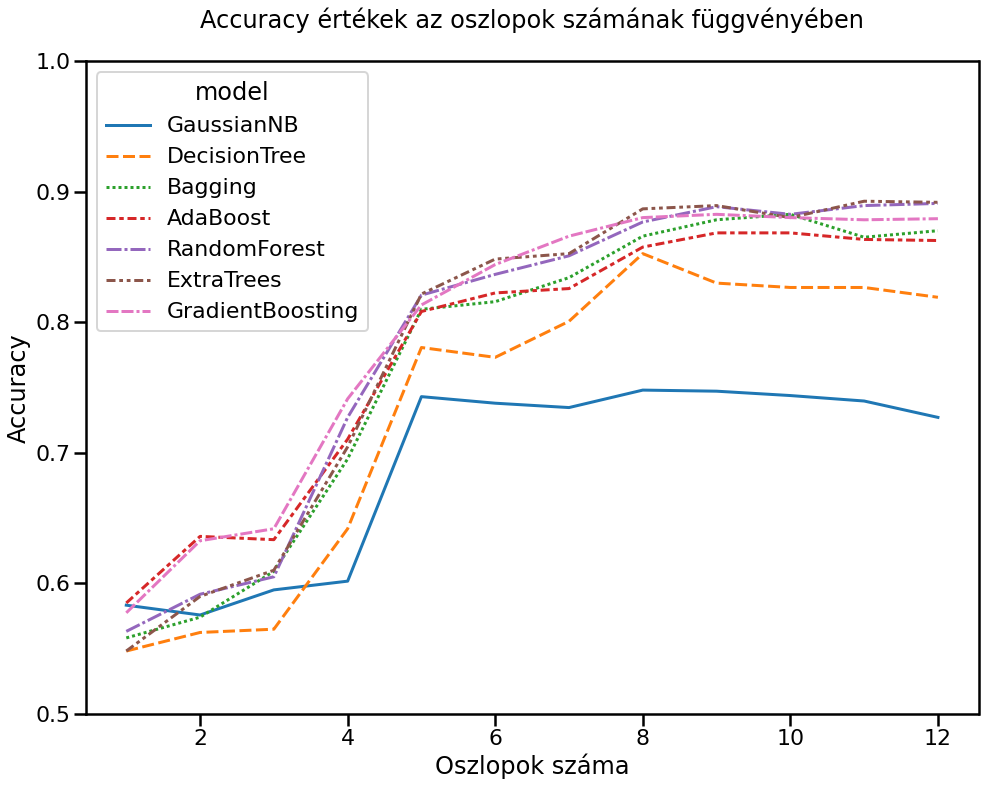

In [13]:
plt.figure(figsize=(16, 12))
ax = sns.lineplot(data=accuracy_results)

plt.title("Accuracy értékek az oszlopok számának függvényében\n")
plt.xlabel("Oszlopok száma")
plt.ylabel("Accuracy")
ylim = plt.ylim(0.5,1.0)

## ROC AUC értékek csak az első oszlop használata esetén

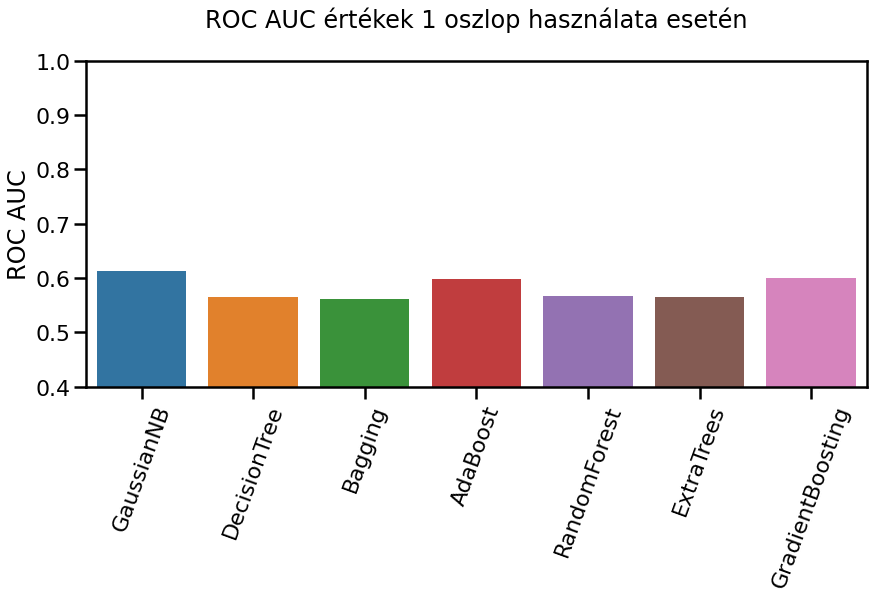

In [14]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="model", y="roc_auc", data=results[results["number_of_columns"] == 1])
xticks = plt.xticks(rotation=70)

plt.title("ROC AUC értékek 1 oszlop használata esetén\n")
plt.xlabel("")
plt.ylabel("ROC AUC")
ylim = plt.ylim(0.4,1.0)

## ROC AUC értékek az összes oszlop használata esetén

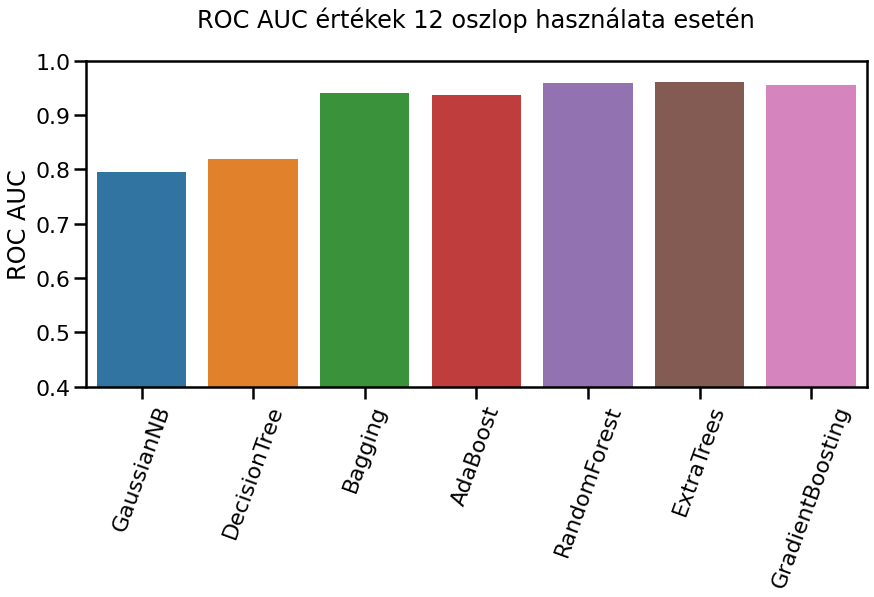

In [15]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="model", y="roc_auc", data=results[results["number_of_columns"] == max_number_of_columns])
xticks = plt.xticks(rotation=70)

plt.title(f"ROC AUC értékek {max_number_of_columns} oszlop használata esetén\n")
plt.xlabel("")
plt.ylabel("ROC AUC")
ylim = plt.ylim(0.4,1.0)

## ROC AUC értékek az osztályozáshoz kiválasztott oszlopok számának függvényében:

In [16]:
roc_auc_results = results.pivot(index ="number_of_columns", columns ="model", values ="roc_auc")
roc_auc_results = roc_auc_results.reindex( columns = ["GaussianNB","DecisionTree","Bagging","AdaBoost",
                                                      "RandomForest","ExtraTrees","GradientBoosting"])
roc_auc_results

model,GaussianNB,DecisionTree,Bagging,AdaBoost,RandomForest,ExtraTrees,GradientBoosting
number_of_columns,,,,,,,
1,0.612240,0.565201,0.561078,0.597406,0.566352,0.565719,0.599056
2,0.639086,0.571170,0.616611,0.697111,0.626452,0.606399,0.704835
3,0.641569,0.574483,0.636181,0.690712,0.649758,0.630163,0.705267
4,0.676498,0.639871,0.749303,0.772903,0.773138,0.763664,0.800465
5,0.806219,0.780247,0.876200,0.886299,0.893351,0.895214,0.905015
6,0.813738,0.773333,0.893401,0.897318,0.918403,0.916375,0.922525
7,0.805907,0.800296,0.913659,0.913306,0.934291,0.932677,0.937250
8,0.819039,0.852281,0.938631,0.933091,0.954560,0.953782,0.952654
9,0.817041,0.829084,0.946435,0.938564,0.956199,0.957733,0.953933


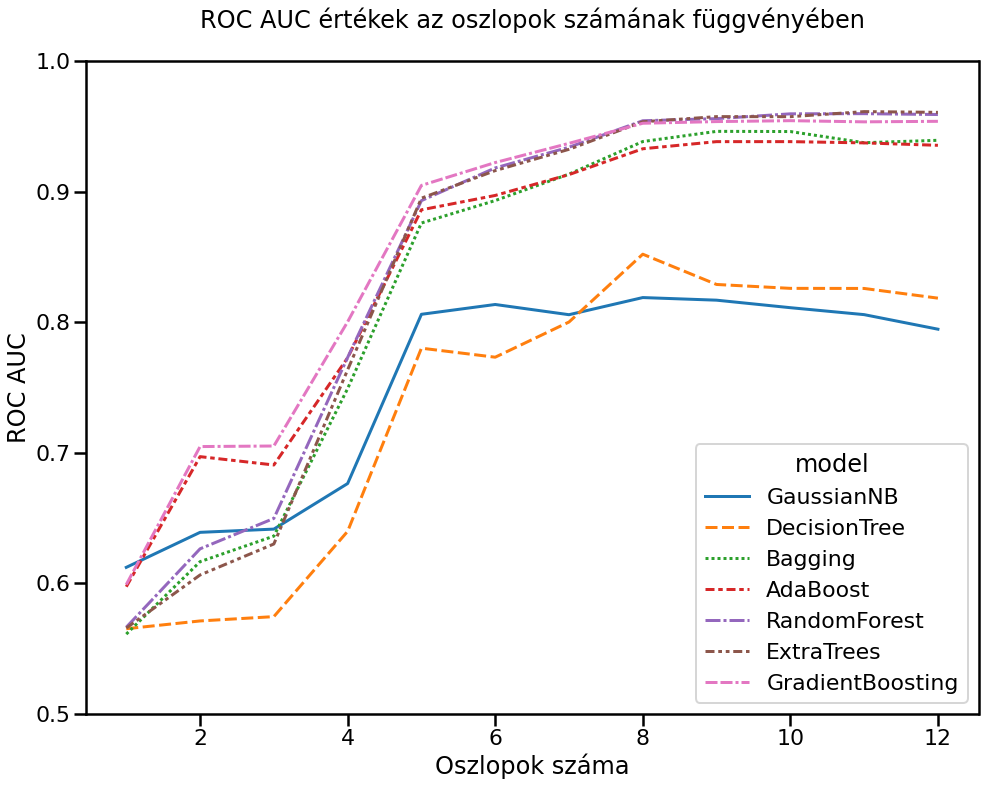

In [17]:
plt.figure(figsize=(16, 12))
ax = sns.lineplot(data=roc_auc_results)

plt.title("ROC AUC értékek az oszlopok számának függvényében\n")
plt.xlabel("Oszlopok száma")
plt.ylabel("ROC AUC")
ylim = plt.ylim(0.5,1.0)

## ROC AUC értékek és Accuracy értékek trendjének összevetése

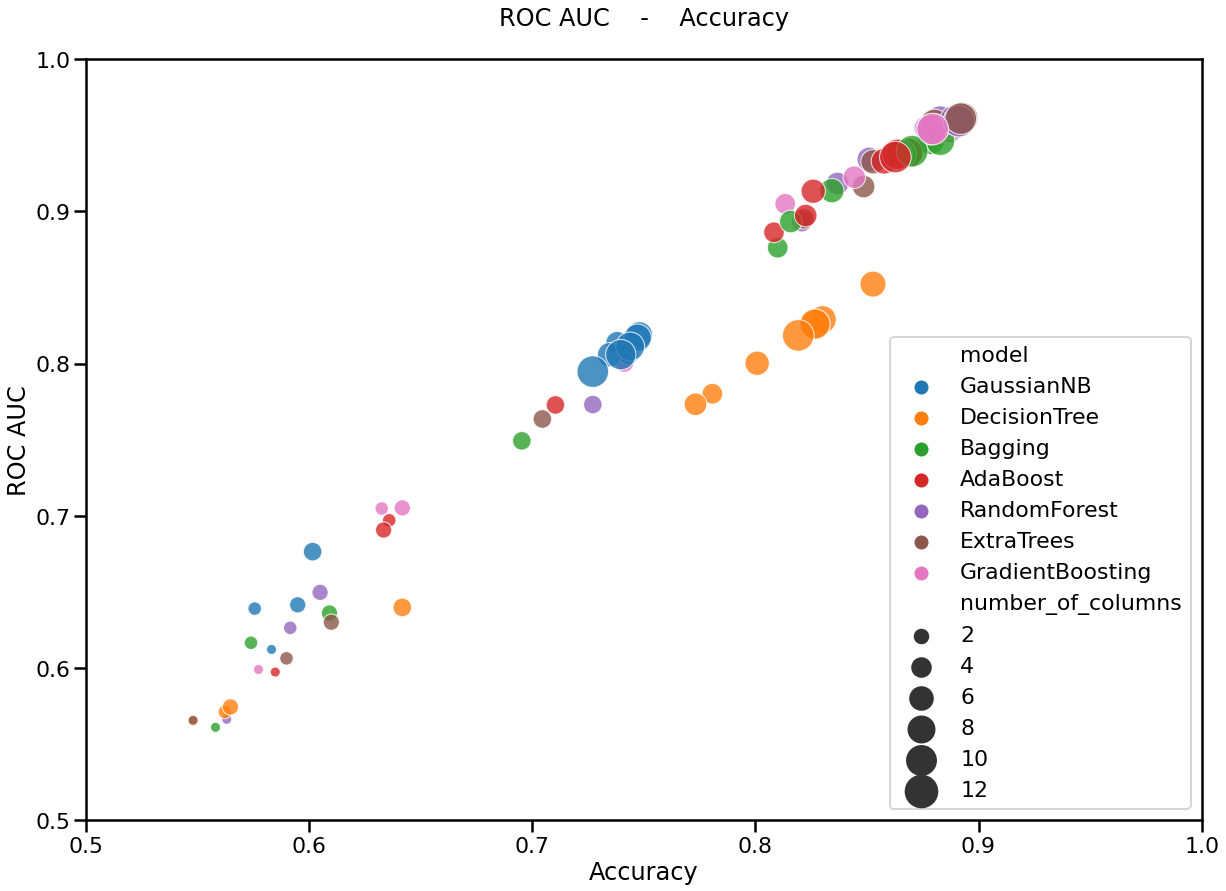

In [18]:
plt.figure(figsize=(20, 14))

ax = sns.scatterplot(x="accuracy", y="roc_auc", data=results, hue="model",
                     size="number_of_columns", sizes=(100,1000), alpha=0.8)

plt.title("ROC AUC    -    Accuracy\n")
plt.xlabel("Accuracy")
plt.ylabel("ROC AUC")
plt.xlim(0.5,1.0)
plt.ylim(0.5,1.0)
legend = plt.legend(loc='lower right')

## Összefoglalás



A felügyelt tanulást végző osztályozó algoritmusokat csak alapbeállításokkal, keresztvalidációs paraméter hangolás nélkül teszteltem, egy nagy adathalmaz bizonyos részhalmazán.

Ezt az egyszerű adathalmazt és módszert használva mindegyik osztályozó algoritmusra igaz, hogy az inputként használt oszlopok számának növelésével kezdetben javul az osztályozásuk minősége, ugyanakkor az egyszerű osztályozók hamarabb érik el a legjobb osztályozó képességüket és ezután elkezdenek túltanulni.

Az összetett algoritmusok kisebb oszlopszám esetén nem feltétlenül érik el az egyszerű algoritmusok osztályozási képességeit, ellenben az oszlopszám növelésésvel meredekebben javul osztályozó képességük, ráadásul a túltanulásuk is csak később kezdődik el.
